✅ Annotators who coded all 15 articles: ['Assia', 'Elisa', 'Luigia', 'Yara']

=== Frame: Foreign influence threat_present ===
Pairwise Krippendorff's alpha (alpha, number of articles):
  Assia vs Elisa: α = 0.000, articles = 15
  Assia vs LLM: α = -0.036, articles = 15
  Assia vs Luigia: α = 0.000, articles = 15
  Assia vs Yara: α = 1.000, articles = 15
  Elisa vs LLM: α = 0.642, articles = 15
  Elisa vs Luigia: α = -0.036, articles = 15
  Elisa vs Yara: α = 0.000, articles = 15
  Luigia vs LLM: α = -0.074, articles = 15
  Luigia vs Yara: α = 0.000, articles = 15
  Yara vs LLM: α = -0.036, articles = 15

Average pairwise alpha per coder:
  Assia: 0.241
  Elisa: 0.152
  Luigia: -0.027
  Yara: 0.241
  LLM: 0.124

✅ Overall Krippendorff's alpha: α = 0.088
Foreign influence threat_present: 3 articles with coder disagreement
Foreign influence threat_present: 12 articles with coder agreement
Foreign influence threat_present: 15 articles coded by all coders

=== Frame: Systemic institutional 

/tmp/ipykernel_613731/2958494343.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=results_df_sorted, x="overall_alpha", y="frame", palette="viridis")


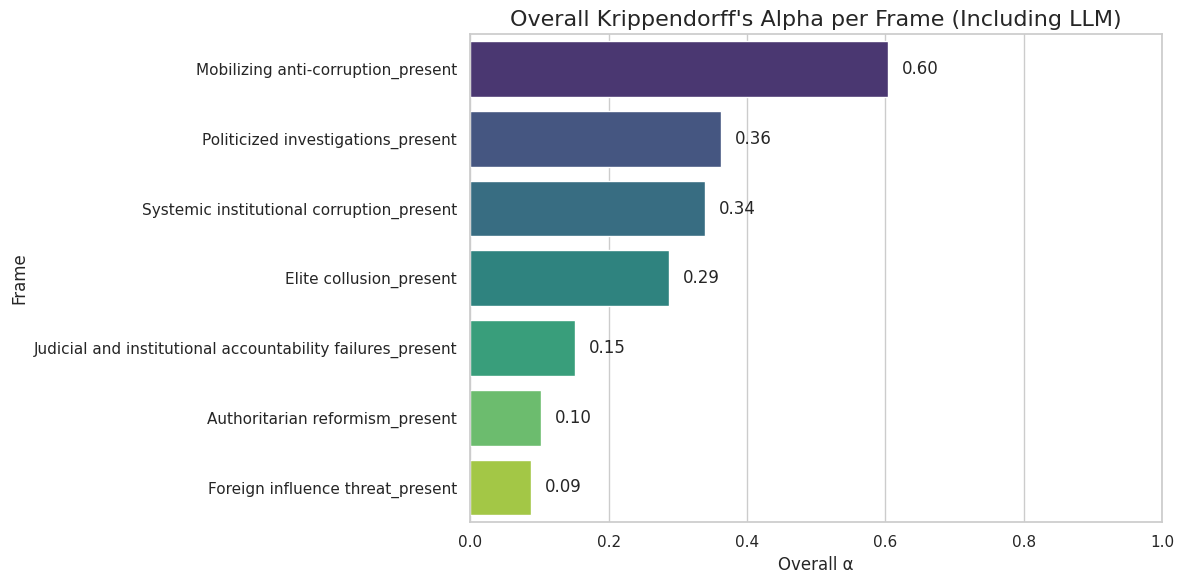

In [91]:
import os
import json
import pandas as pd
import numpy as np
import krippendorff
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIG ===
SESSION_FOLDER = os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/sessions/")
LLM_FILE = os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/annotations/coding_frames/ICR/news_sample_with_7_frames_intercoder.csv")

# Frame labels used in analysis
FRAME_LABELS = [
    "Foreign influence threat_present",
    "Systemic institutional corruption_present",
    "Elite collusion_present",
    "Politicized investigations_present",
    "Authoritarian reformism_present",
    "Judicial and institutional accountability failures_present",
    "Mobilizing anti-corruption_present"
]

# Mapping to CSV columns like 'frame_1_name'
FRAME_NAME_TO_COLUMN = {
    "Foreign influence threat_present": "frame_1_name",
    "Systemic institutional corruption_present": "frame_2_name",
    "Elite collusion_present": "frame_3_name",
    "Politicized investigations_present": "frame_4_name",
    "Authoritarian reformism_present": "frame_5_name",
    "Judicial and institutional accountability failures_present": "frame_6_name",
    "Mobilizing anti-corruption_present": "frame_7_name"
}

# === HELPERS ===
def encode_label(val):
    return 1 if val == "Present" else 0 if val == "Not Present" else None

def load_all_annotations():
    data = []
    for filename in os.listdir(SESSION_FOLDER):
        if filename.endswith("_session.json"):
            user_id = filename.replace("_session.json", "")
            path = os.path.join(SESSION_FOLDER, filename)
            with open(path, "r", encoding="utf-8") as f:
                session_data = json.load(f)
                annotations = session_data.get("annotations", [])
                for ann in annotations:
                    ann["user_id"] = user_id
                    data.append(ann)
    df = pd.DataFrame(data)

    # Only consider selected annotators
    allowed_annotators = ["Assia", "Alexander", "Elisa", "Luigia", "Yara"]
    df = df[df["user_id"].isin(allowed_annotators)]

    # ✅ Only keep annotators who coded all 15 articles
    annotator_counts = df.groupby("user_id")["uri"].nunique()
    complete_annotators = annotator_counts[annotator_counts == 15].index.tolist()
    df = df[df["user_id"].isin(complete_annotators)]

    print(f"✅ Annotators who coded all 15 articles: {complete_annotators}")
    return df


def prepare_matrix(df, frame_label):
    df_sub = df[["user_id", "uri", frame_label]].copy()
    df_sub[frame_label] = df_sub[frame_label].map(encode_label)
    pivot = df_sub.pivot(index="uri", columns="user_id", values=frame_label)
    return pivot

def safe_krippendorff_alpha(data, level='nominal'):
    unique_vals = np.unique(data[~np.isnan(data)])
    if len(unique_vals) < 2:
        return 1.0
    try:
        alpha = krippendorff.alpha(reliability_data=data, level_of_measurement=level)
        return alpha if not isinstance(alpha, (np.ndarray, list)) else np.nan
    except Exception as e:
        print(f"⚠️ Error computing alpha: {e}")
        return np.nan

def pairwise_krippendorff(matrix, coders):
    pairwise_results = {}
    for coder1, coder2 in combinations(coders, 2):
        pair_data = matrix[[coder1, coder2]].dropna()
        n_rows = pair_data.shape[0]
        alpha = safe_krippendorff_alpha(pair_data.to_numpy().T) if n_rows > 0 else np.nan
        if n_rows == 0:
            print(f"⚠️ No overlapping articles for {coder1} vs {coder2}")
        pairwise_results[(coder1, coder2)] = (alpha, n_rows)
    return pairwise_results

# === MAIN FUNCTION ===
def compute_fine_grained_reliability():
    df = load_all_annotations()
    coders = df["user_id"].unique()

    # Load LLM annotations
    llm_df = pd.read_csv(LLM_FILE)
    llm_df["user_id"] = "LLM"

    frame_results = []

    for frame_label in FRAME_LABELS:
        print(f"\n=== Frame: {frame_label} ===")

        # Prepare human matrix
        matrix = prepare_matrix(df, frame_label)

        # Get corresponding column in LLM file
        llm_column = FRAME_NAME_TO_COLUMN[frame_label]
        llm_frame_data = llm_df[["uri", llm_column]].copy()
        llm_frame_data[llm_column] = llm_frame_data[llm_column].apply(
            lambda x: "Present" if isinstance(x, str) and x.strip() != "" else "Not Present"
        )
        llm_frame_data[llm_column] = llm_frame_data[llm_column].map(encode_label)
        llm_frame_data = llm_frame_data.set_index("uri").rename(columns={llm_column: "LLM"})

        # Merge
        combined_matrix = matrix.join(llm_frame_data, how="outer")
        coders_with_data = [c for c in combined_matrix.columns if combined_matrix[c].notna().any()]

        if len(coders_with_data) < 2:
            print("Not enough coders with data to compute reliability.")
            frame_results.append({
                "frame": frame_label,
                "overall_alpha": np.nan,
                "avg_pairwise_alpha": np.nan,
                "num_disagreements": 0,
                "num_agreements": 0,
                "num_articles_coded_by_all": 0
            })
            continue

        # Pairwise alphas
        pairwise_alphas = pairwise_krippendorff(combined_matrix, coders_with_data)
        print("Pairwise Krippendorff's alpha (alpha, number of articles):")
        for (c1, c2), (alpha, n_rows) in sorted(pairwise_alphas.items()):
            print(f"  {c1} vs {c2}: α = {alpha:.3f}, articles = {n_rows}" if not np.isnan(alpha)
                  else f"  {c1} vs {c2}: α = N/A, articles = {n_rows}")

        # Per coder average
        coder_scores = {coder: [] for coder in coders_with_data}
        for (c1, c2), (alpha, _) in pairwise_alphas.items():
            if not np.isnan(alpha):
                coder_scores[c1].append(alpha)
                coder_scores[c2].append(alpha)

        print("\nAverage pairwise alpha per coder:")
        for coder, scores in coder_scores.items():
            print(f"  {coder}: {np.mean(scores):.3f}" if scores else f"  {coder}: No scores")

        # Overall alpha
        complete_data = combined_matrix.dropna(how='any')
        num_articles_coded_by_all = complete_data.shape[0]
        overall_alpha = safe_krippendorff_alpha(complete_data.to_numpy().T) if num_articles_coded_by_all > 0 else np.nan
        print(f"\n✅ Overall Krippendorff's alpha: α = {overall_alpha:.3f}" if not np.isnan(overall_alpha)
              else "\n⚠️ No article coded by all coders — can't compute overall alpha.")

        # Agreement/disagreement
        disagreement_count = complete_data.apply(lambda row: len(set(row)), axis=1)
        num_disagreements = (disagreement_count > 1).sum()
        num_agreements = (disagreement_count == 1).sum()

        print(f"{frame_label}: {num_disagreements} articles with coder disagreement")
        print(f"{frame_label}: {num_agreements} articles with coder agreement")
        print(f"{frame_label}: {num_articles_coded_by_all} articles coded by all coders")

        frame_results.append({
            "frame": frame_label,
            "overall_alpha": overall_alpha,
            "avg_pairwise_alpha": np.mean([v[0] for v in pairwise_alphas.values() if not np.isnan(v[0])]) if pairwise_alphas else np.nan,
            "num_disagreements": num_disagreements,
            "num_agreements": num_agreements,
            "num_articles_coded_by_all": num_articles_coded_by_all
        })

    results_df = pd.DataFrame(frame_results)
    results_df.to_excel("reliability_results_with_llm.xlsx", index=False)
    print("\n✅ Results saved to 'reliability_results_with_llm.xlsx'")
    return results_df

# === PLOT FUNCTION ===
def plot_results(results_df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    results_df_sorted = results_df.sort_values("overall_alpha", ascending=False)

    ax = sns.barplot(data=results_df_sorted, x="overall_alpha", y="frame", palette="viridis")
    ax.set_title("Overall Krippendorff's Alpha per Frame (Including LLM)", fontsize=16)
    ax.set_xlabel("Overall α", fontsize=12)
    ax.set_ylabel("Frame", fontsize=12)
    ax.set_xlim(0, 1)

    for i, val in enumerate(results_df_sorted["overall_alpha"]):
        if not np.isnan(val):
            ax.text(val + 0.02, i, f"{val:.2f}", va='center')

    plt.tight_layout()
    plt.show()

# === RUN ===
if __name__ == "__main__":
    results_df = compute_fine_grained_reliability()
    print("\n=== Summary DataFrame ===")
    print(results_df)
    plot_results(results_df)

In [90]:
results_df

,frame,overall_alpha,avg_pairwise_alpha,num_disagreements,num_agreements,num_articles_coded_by_all
0,Foreign influence threat_present,0.194932,0.261758,2,13,15
1,Systemic institutional corruption_present,0.329877,0.315596,6,9,15
2,Elite collusion_present,0.297619,0.292935,10,5,15
3,Politicized investigations_present,0.385417,0.386698,7,8,15
4,Authoritarian reformism_present,-0.072727,-0.055827,5,10,15
5,Judicial and institutional accountability fail...,0.065611,0.036327,12,3,15
6,Mobilizing anti-corruption_present,0.581560,0.546274,4,11,15


In [94]:
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

def export_agreement_with_yara_and_text(df, llm_df, output_path="agreement_with_yara_and_text.xlsx"):
    wb = Workbook()
    wb.remove(wb.active)  # Remove default sheet

    # Merge translated text
    translated_texts = llm_df.set_index("uri")["translated_text"]

    for frame_label in FRAME_LABELS:
        frame_col = frame_label
        llm_col = FRAME_NAME_TO_COLUMN[frame_label]

        # Prepare human annotations
        matrix = prepare_matrix(df, frame_label)

        # Add LLM
        llm_frame_data = llm_df[["uri", llm_col]].copy()
        llm_frame_data[llm_col] = llm_frame_data[llm_col].apply(lambda x: "Present" if isinstance(x, str) and x.strip() != "" else "Not Present")
        llm_frame_data[llm_col] = llm_frame_data[llm_col].map(encode_label)
        llm_frame_data = llm_frame_data.set_index("uri").rename(columns={llm_col: "LLM"})

        # Join LLM + Human annotations
        combined_matrix = matrix.join(llm_frame_data)

        # Add Yara if missing
        if "Yara" not in combined_matrix.columns:
            print(f"⚠️ Skipping {frame_label} — Yara missing")
            continue

        # Add translated text
        combined_matrix["translated_text"] = translated_texts

        # Compute agreement with Yara
        yara_vector = combined_matrix["Yara"]
        agreement_df = combined_matrix.drop(columns=["Yara", "translated_text"]).copy()
        for col in agreement_df.columns:
            agreement_df[col] = agreement_df[col] == yara_vector

        # Create worksheet
        sheet_title = frame_label[:31]
        ws = wb.create_sheet(title=sheet_title)

        # Header
        ws.append(["URI", "Translated Text"] + list(agreement_df.columns) + ["Yara"])

        green_fill = PatternFill(start_color="C6EFCE", end_color="C6EFCE", fill_type="solid")  # Green
        red_fill = PatternFill(start_color="FFC7CE", end_color="FFC7CE", fill_type="solid")    # Red

        for uri in combined_matrix.index:
            text = combined_matrix.loc[uri, "translated_text"]
            row = [uri, text]

            # Add coder values
            for col in agreement_df.columns:
                val = combined_matrix.loc[uri, col]
                row.append(val)

            # Add Yara last
            yara_val = combined_matrix.loc[uri, "Yara"]
            row.append(yara_val)
            ws.append(row)

        # Color cells based on agreement
        for i, uri in enumerate(combined_matrix.index, start=2):  # skip header
            for j, col in enumerate(agreement_df.columns, start=3):  # 1=uri, 2=text
                cell = ws.cell(row=i, column=j)
                agrees = agreement_df.loc[uri, col]
                val = combined_matrix.loc[uri, col]
                yara_val = combined_matrix.loc[uri, "Yara"]

                if pd.isna(val) or pd.isna(yara_val):
                    continue
                if agrees:
                    cell.fill = green_fill
                else:
                    cell.fill = red_fill

    wb.save(output_path)
    print(f"✅ Agreement Excel saved to: {output_path}")

In [96]:
if __name__ == "__main__":
    results_df = compute_fine_grained_reliability()

    # Load input again
    df = load_all_annotations()
    llm_df = pd.read_csv(LLM_FILE)
    llm_df["user_id"] = "LLM"

    export_agreement_with_yara_and_text(df, llm_df, output_path=os.path.expanduser("~/webdav/ASCOR-FMG-5580-RESPOND-news-data (Projectfolder)/annotations/coding_frames/ICR/agreement_with_yara_and_text.xlsx"))

✅ Annotators who coded all 15 articles: ['Assia', 'Elisa', 'Luigia', 'Yara']

=== Frame: Foreign influence threat_present ===
Pairwise Krippendorff's alpha (alpha, number of articles):
  Assia vs Elisa: α = 0.000, articles = 15
  Assia vs LLM: α = -0.036, articles = 15
  Assia vs Luigia: α = 0.000, articles = 15
  Assia vs Yara: α = 1.000, articles = 15
  Elisa vs LLM: α = 0.642, articles = 15
  Elisa vs Luigia: α = -0.036, articles = 15
  Elisa vs Yara: α = 0.000, articles = 15
  Luigia vs LLM: α = -0.074, articles = 15
  Luigia vs Yara: α = 0.000, articles = 15
  Yara vs LLM: α = -0.036, articles = 15

Average pairwise alpha per coder:
  Assia: 0.241
  Elisa: 0.152
  Luigia: -0.027
  Yara: 0.241
  LLM: 0.124

✅ Overall Krippendorff's alpha: α = 0.088
Foreign influence threat_present: 3 articles with coder disagreement
Foreign influence threat_present: 12 articles with coder agreement
Foreign influence threat_present: 15 articles coded by all coders

=== Frame: Systemic institutional 